In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch

In [3]:
import pandas as pd
import numpy as np
import json
import random
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import recall_score,precision_score,make_scorer
from gensim.parsing.porter import PorterStemmer

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/{'.//'}

%cd LoyalAI
%ls

Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/LoyalAI
cnn.ipynb       LoyalAI.ipynb  model.pt  train.csv
data_full.json  metrics.pt     test.csv  valid.csv


In [5]:
with open('data_full.json', 'r') as file:
    all_data = json.load(file)
#     print(len(dic))
    
oos_train_df = pd.DataFrame(all_data["oos_train"])
oos_val_df = pd.DataFrame(all_data["oos_val"])
oos_test_df = pd.DataFrame(all_data["oos_test"])

ins_train_df = pd.DataFrame(all_data["train"])
ins_val_df = pd.DataFrame(all_data["val"])
ins_test_df = pd.DataFrame(all_data["test"])
# ins_train_df.describe()

In [6]:
seed = 2
random.seed(a=seed)
arr = random.sample([i for i in range(150)], k=20)
names = pd.unique(ins_train_df[1])
picked = [names[i] for i in arr]
# print(names)
in_train = ins_train_df.loc[ins_train_df[1].isin(picked)]
in_train.describe()

in_test = ins_test_df.loc[ins_test_df[1].isin(picked)]
in_val = ins_val_df.loc[ins_val_df[1].isin(picked)]

In [7]:
train = pd.concat([in_train, oos_train_df])
test = pd.concat([in_test, oos_test_df])
val = pd.concat([in_val, oos_val_df])

In [8]:
from gensim.utils import simple_preprocess
train['token'] = [simple_preprocess(line, deacc=True) for line in train[0]] 
test['token'] = [simple_preprocess(line, deacc=True) for line in test[0]] 
val['token'] = [simple_preprocess(line, deacc=True) for line in val[0]] 

In [9]:
in_train.head(10)
input_features, y_train = train['token'], train[1]
X_val, y_val = val['token'], val[1]
X_test, y_test = test['token'], test[1]

In [10]:
porter_stemmer = PorterStemmer()
new_input2 = pd.DataFrame(input_features).reset_index(drop=True)
new_input2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_input2['token']]
# blah

new_test2 = pd.DataFrame(X_test).reset_index(drop=True)
new_test2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_test2['token']]

new_val2 = pd.DataFrame(X_val).reset_index(drop=True)
new_val2['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in text] for text in new_val2['token']]

In [11]:
train_features = [' '.join(first) for first in new_input2['stemmed_tokens']]
# input_features[0]

test_features = [' '.join(first) for first in new_test2['stemmed_tokens']]

val_features = [' '.join(first) for first in new_val2['stemmed_tokens']]

In [14]:
from gensim.models import Word2Vec
import pickle
size = 500
window = 3
min_count = 1
workers = 1
sg = 1
OUTPUT_FOLDER = ''

# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
    with open(word2vec_file, "wb") as f:
        pickle.dump(w2v_model, f)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(new_input2['stemmed_tokens'], padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)
#new_input2['stemmed_tokens']


2100


In [15]:
max_sen_len = new_input2['stemmed_tokens'].map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
#     print(sentence)
    for word in sentence.split(" "):
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            #print(word)
        else:
#             print("BLAH BLAH ",word, " black sheep")
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [16]:
encoded_y = np.where(y_train!='oos', 0, 1)
y_true_val = np.where(y_val!='oos', 0, 1)
y_true_test = np.where(y_test!='oos', 0, 1)

In [17]:
device = 'cpu'
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)

In [18]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + 'models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            #print("x2",x2.shape)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [23]:
sdf = pd.DataFrame(train_features,
                         columns=['stemmed_tokens'])
# sdf = train_features #new_input2['stemmed_tokens']
# sdf.head()

sdf_test = pd.DataFrame(test_features,
                         columns=['stemmed_tokens'])
# sdf_test['stemmed_tokens'] = test_features #new_test2['stemmed_tokens']
sdf_test.head()

sdf_val = pd.DataFrame(val_features,
                         columns=['stemmed_tokens'])
# sdf_val['stemmed_tokens'] = val_features #new_val2['stemmed_tokens']
sdf_val.head()

,stemmed_tokens
0,is travel to franc safe
1,is franc safe to travel to
2,need to know is travel to franc safe
3,can travel to franc as far as safeti goe
4,can safe travel to franc or is it danger


In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(sdf, encoded_y)
X_over, y_over = oversample.fit_resample(sdf, encoded_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
X_over = pd.DataFrame(X_over, columns=['stemmed_tokens'])
X_under = pd.DataFrame(X_under, columns=['stemmed_tokens'])
# X_over, X_under

In [29]:
NUM_CLASSES = 2
VOCAB_SIZE = len(w2vmodel.wv.vocab)
device = 'cpu'
cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)
num_epochs = 30

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()

for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_under.iterrows(): #sdf
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens']) #0
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)
#         print(probs, target)
        # Get the target label
        target = make_target(y_over[index]) #encoded_y

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(sdf)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding2.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
# print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Epoch3
Epoch ran :3
Epoch4
Epoch ran :4
Epoch5
Epoch ran :5
Epoch6
Epoch ran :6
Epoch7
Epoch ran :7
Epoch8
Epoch ran :8
Epoch9
Epoch ran :9
Epoch10
Epoch ran :10
Epoch11
Epoch ran :11
Epoch12
Epoch ran :12
Epoch13
Epoch ran :13
Epoch14
Epoch ran :14
Epoch15
Epoch ran :15
Epoch16
Epoch ran :16
Epoch17
Epoch ran :17
Epoch18
Epoch ran :18
Epoch19
Epoch ran :19
Epoch20
Epoch ran :20
Epoch21
Epoch ran :21
Epoch22
Epoch ran :22
Epoch23
Epoch ran :23
Epoch24
Epoch ran :24
Epoch25
Epoch ran :25
Epoch26
Epoch ran :26
Epoch27
Epoch ran :27
Epoch28
Epoch ran :28
Epoch29
Epoch ran :29
Epoch30
Epoch ran :30
Input vector
[[   3    2  231 1292 1293   13   62 1294   33 1295 1295 1295 1295 1295
  1295 1295 1295 1295 1295 1295 1295 1295]]
Probs
tensor([[1.0000e+00, 9.0761e-08]], grad_fn=<SoftmaxBackward>)


Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       600
           1       0.00      0.00      0.00      1000

    accuracy                           0.38      1600
   macro avg       0.19      0.50      0.27      1600
weighted avg       0.14      0.38      0.20      1600



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


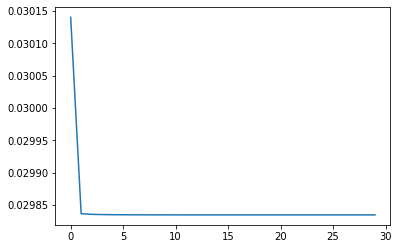

In [30]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER +'plots/'+ 'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in sdf_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(y_true_test[index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
# print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
# fig.savefig(OUTPUT_FOLDER +'plots/' + 'loss_plt_500_padding_30_epochs.pdf")

